In [1]:
#general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from sklearn.preprocessing import StandardScaler
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Project description:
Each of the V features are principal components obtained with PCA
without counting the two features: 'Time' and 'Amount'
* 'Time':seconds elapsed between each transaction and the first transaction in the dataset
* 'Amount': transaction amount

The Class response variable:
* ‘1’ : in case of fraud and 
* ‘0’ : Not fraud

### Assumptions:
* duplicate rows reflect reality and have value (i.e. duplicates are not dropped), and that the dataset is weighted correctly and we do not need to normalize the data.

In [2]:
def metrics(actuals, predictions):
    """
    a function to format and output metrics reflecting how good the ML models are when using various techniques
    """
    print("Accuracy: {:.5f}".format(accuracy_score(actuals, predictions)))
    print("Precision: {:.5f}".format(precision_score(actuals, predictions)))
    print("Recall: {:.5f}".format(recall_score(actuals, predictions)))
    print("F1-score: {:.5f}".format(f1_score(actuals, predictions)))

# Loading in the data

In [3]:
data = pd.read_csv('Creditcard.csv')
#note: you need to download the data and put it in this working directory. the gitignore file is set to not push this dataset. 
# data can be found here: https://drive.google.com/file/d/1yDluWXKfBtQvDm3aJ_1ML701EXoBCu77/view?usp=sharing

# Preliminary data exploration and minor analysis:

In [4]:
#looking at the columns in the dataset  and the dataset's shape, previewing the heead of the dataframe
print("Shape of data: ", data.shape)
print(data.columns)
data.head()

Shape of data:  (284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
#looking at the information reguarding completeness of the data:
print(data.isnull().values.any())
data.info()

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21 

In [6]:
#looking at descriptive stats for the dataset:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [7]:
#checking for the class categorization value counts:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

# Data Visualization

In [8]:
# determine the number of fraud cases
fraud_df = data[data['Class'] == 1]
not_fraud_df = data[data['Class'] == 0]
fraud_percentage = (len(fraud_df)/(len(fraud_df)+len(not_fraud_df)))*100

print('Fraud Cases: {}'.format(len(fraud_df)))
print('Valid Cases: {}'.format(len(not_fraud_df)))
print('Fraud Percentage: {}'.format(fraud_percentage))

Fraud Cases: 492
Valid Cases: 284315
Fraud Percentage: 0.1727485630620034


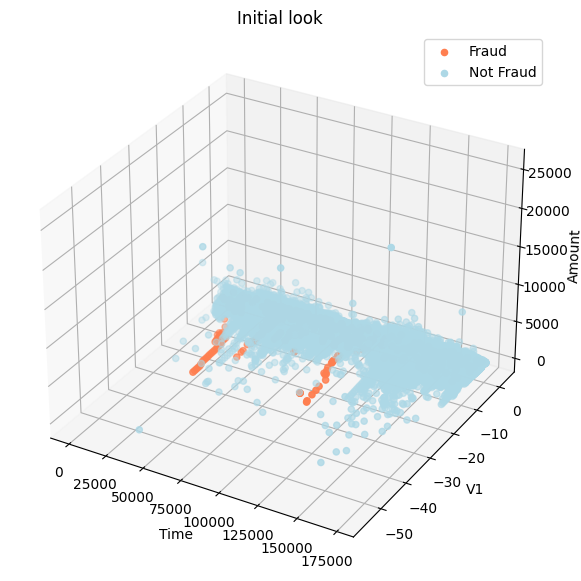

In [9]:
#got an error: "ValueError: Unknown projection '3d'"
#this solution from: https://stackoverflow.com/questions/3810865/matplotlib-unknown-projection-3d-error
from mpl_toolkits.mplot3d import axes3d, Axes3D

#Z axis will be V1
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

#Fraud
x=fraud_df['Time']
y=fraud_df['V1']
z=fraud_df["Amount"]
ax.scatter(x, y, z, c='coral',label='Fraud')
#Not Fraud
x=not_fraud_df['Time']
y=not_fraud_df['V1']
z=not_fraud_df["Amount"]
ax.scatter(x, y, z, c='lightblue', label='Not Fraud')
#adding some details on the plot
ax.set_title("Initial look")
ax.set_xlabel("Time")
ax.set_ylabel("V1")
ax.set_zlabel("Amount")
plt.legend()
plt.show()

# Test Train Split:

In [10]:
# naming the dependent "y" variable the class output
y_variable = data["Class"]
# naming the "x" independent variable all of the other data
x_variable = data.drop(["Class"], axis= 1)

In [11]:
(train_X, test_X, train_Y, test_Y) = train_test_split(x_variable, y_variable, test_size= 0.3, random_state= 42)
print("Shape of train_X: ", train_X.shape)
print("Shape of test_X: ", test_X.shape)

Shape of train_X:  (199364, 30)
Shape of test_X:  (85443, 30)


# Training the models

## Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_X, train_Y)
predictions_dt = decision_tree.predict(test_X)
decision_tree_score = decision_tree.score(test_X, test_Y) * 100
print("Decision Tree Score: ", decision_tree_score)

Decision Tree Score:  99.9133925541004


In [13]:
confusion_matrix_dt = confusion_matrix(test_Y, predictions_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt)

Confusion Matrix - Decision Tree
[[85263    44]
 [   30   106]]


In [14]:
print("Evaluation of Decision Tree Model")
print()
metrics(test_Y, predictions_dt.round())

Evaluation of Decision Tree Model

Accuracy: 0.99913
Precision: 0.70667
Recall: 0.77941
F1-score: 0.74126


## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(train_X, train_Y)
predictions_rf = random_forest.predict(test_X)
random_forest_score = random_forest.score(test_X, test_Y) * 100
print("Random Forest Score: ", random_forest_score)

Random Forest Score:  99.96137776061234


In [16]:
confusion_matrix_rf = confusion_matrix(test_Y, predictions_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

Confusion Matrix - Random Forest
[[85301     6]
 [   27   109]]


In [17]:
print("Evaluation of Random Forest Model:")
metrics(test_Y, predictions_rf.round())

Evaluation of Random Forest Model:
Accuracy: 0.99961
Precision: 0.94783
Recall: 0.80147
F1-score: 0.86853


## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="lbfgs")
lr.fit(train_X, train_Y)
predictions_Log = lr.predict(test_X)

In [19]:
confusion_matrix_kNN = confusion_matrix(test_Y, predictions_Log.round())
print("Confusion Matrix - Logistic Regression")
print(confusion_matrix_kNN)

Confusion Matrix - Logistic Regression
[[85240    67]
 [   46    90]]


In [20]:
print("Evaluation of Logistic Regression Model")
print()
metrics(test_Y, predictions_Log.round())

Evaluation of Logistic Regression Model

Accuracy: 0.99868
Precision: 0.57325
Recall: 0.66176
F1-score: 0.61433


## XGBoost 

In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth = 4)
xgb.fit(train_X, train_Y)
predictions_XGBoost = xgb.predict(test_X)

In [22]:
confusion_matrix_XGBoost = confusion_matrix(test_Y, predictions_XGBoost.round())
print("Confusion Matrix - XGBoost")
print(confusion_matrix_XGBoost)

Confusion Matrix - XGBoost
[[85300     7]
 [   23   113]]


In [23]:
print("Evaluation of XGBoost Model")
print()
metrics(test_Y, predictions_XGBoost.round())

Evaluation of XGBoost Model

Accuracy: 0.99965
Precision: 0.94167
Recall: 0.83088
F1-score: 0.88281


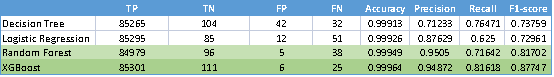

XGBoost Performed best compare to other algorithms for provided data set. Due to performance issues we didn't consider KNN and SVM. Now lets try with ANN

In [24]:
# Creating the ANN model for Credit Card Fraud Detection
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

2023-12-03 23:09:36.506930: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 23:09:36.537684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 23:09:36.537724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 23:09:36.539299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 23:09:36.546172: I tensorflow/core/platform/cpu_feature_guar

In [50]:
# Initializing the ANN
model = Sequential()

Creating a simple NN with following parameters::

fully-connected layers: 5

Activation: ReLu

Input Vector Lenght: 30

Output Activation Function: Sigmoid to classify result as non-fraud (0) or fraud (1)

a dropout step is included to prevent overfitting.

In [48]:
train_X.shape

(199364, 30)

In [49]:
train_Y.shape

(199364,)

In [51]:
# Adding the input layer and first Hidden Layer
model.add(Dense(activation = "relu", input_dim = 30, units = 6, kernel_initializer='uniform' ))

# Adding the Second hidden layer
model.add(Dense(activation = "relu", units =20, kernel_initializer='uniform'))

##add Dropout(0.5) here to prevent overfitting::: wip- Amit

# Adding the third hidden layer
model.add(Dense(activation = "relu", units = 10, kernel_initializer='uniform'))

# Addinng the output Layer
model.add(Dense(activation = 'sigmoid', units =1, kernel_initializer='uniform',))

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 6)                 186       
                                                                 
 dense_20 (Dense)            (None, 20)                140       
                                                                 
 dense_21 (Dense)            (None, 10)                210       
                                                                 
 dense_22 (Dense)            (None, 1)                 11        
                                                                 
Total params: 547 (2.14 KB)
Trainable params: 547 (2.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
# compiling the ANN
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

In [54]:
# Fitting the ANN to the training set
model.fit(train_X, train_Y, batch_size = 100, epochs =10)

Epoch 1/10
1994/1994 [==============================] - 5s 2ms/step - loss: 0.0387 - accuracy: 0.9962
Epoch 2/10
1994/1994 [==============================] - 5s 3ms/step - loss: 0.0231 - accuracy: 0.9982
Epoch 3/10
1994/1994 [==============================] - 4s 2ms/step - loss: 0.0159 - accuracy: 0.9982
Epoch 4/10
1994/1994 [==============================] - 4s 2ms/step - loss: 0.0136 - accuracy: 0.9982
Epoch 5/10
1994/1994 [==============================] - 4s 2ms/step - loss: 0.0133 - accuracy: 0.9982
Epoch 6/10
1994/1994 [==============================] - 4s 2ms/step - loss: 0.0132 - accuracy: 0.9982
Epoch 7/10
1994/1994 [==============================] - 4s 2ms/step - loss: 0.0132 - accuracy: 0.9982
Epoch 8/10
1994/1994 [==============================] - 4s 2ms/step - loss: 0.0135 - accuracy: 0.9982
Epoch 9/10
1994/1994 [==============================] - 4s 2ms/step - loss: 0.0131 - accuracy: 0.9982
Epoch 10/10
1994/1994 [==============================] - 4s 2ms/step - loss: 0.013

In [55]:
# Making the Prediction and Evaluating the model
# Predicting the Test set result
y_pred = model.predict(test_X)
y_pred = (y_pred>0.5)

2671/2671 [==============================] - 3s 1ms/step


In [56]:
confusion_matrix_XGBoost = confusion_matrix(test_Y, y_pred.round())
print("Confusion Matrix - ANN")
print(confusion_matrix_XGBoost)

Confusion Matrix - ANN
[[85307     0]
 [  136     0]]


In [57]:
print("Evaluation of ANN Model")
print()
metrics(test_Y, y_pred.round())

Evaluation of ANN Model

Accuracy: 0.99841
Precision: 0.00000
Recall: 0.00000
F1-score: 0.00000
